# Digital homo- and heterodyne detection

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kstest
from scipy.interpolate import interp1d
import matplotlib as mpl
from statsmodels.distributions.empirical_distribution import ECDF
from qutip import *

## Define operators

In [3]:
N=15

idc = qeye(N)
ida = qeye(2)
N_cav = tensor(num(N), ida)

a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2)) # note that this is not qutip's sigmam() definition

sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

# projections on qubit ground and excited state
proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())

In [4]:
def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

# partial swap interaction
def U_swap(theta):
    H = -1j*theta*(a.dag() * sm + a * sm.dag())
    return H.expm()

## Parameters

In [20]:
# number of trajectories
Ntrajs = 1000

# effective interaction strength
theta = 0.1*np.pi/2

In [13]:
# set number of qubit measurements per trajectory
n_init = 4

# check when cavity is 95 % empty
vac = 5e-2
def find_first_zero(func, tol=vac, max=2000):
    for i in np.arange(max):
        if func(i) < tol:
            return i

def pop_time_evol(step):
    return n_init*np.exp(-step*(theta**2))
    
Nmeas = find_first_zero(pop_time_evol)
Nmeas, 1-vac

(178, 0.95)

In [14]:
Nmeas = 200

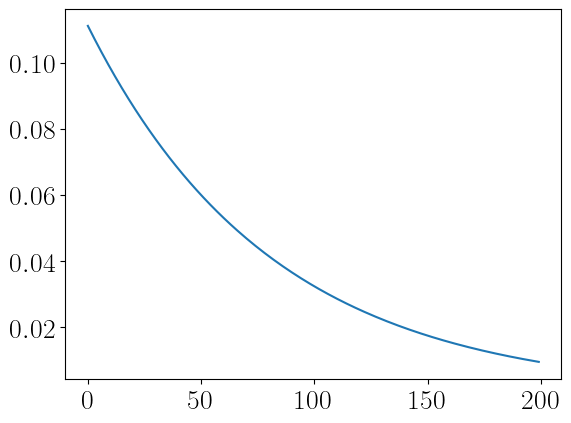

In [15]:
# set weights
nsteps = np.linspace(0,Nmeas-1,Nmeas)
weights=(theta/np.sqrt(2))*np.exp(-nsteps*(theta**2/2))
plt.plot(nsteps,weights);

### Measurement function

In [18]:
# seed 
prng = np.random.RandomState(8758875)

# generate interaction Hamiltonian with strength gint
U_int = U_swap(theta)

# get measurement histogram for one homodyne angle
def get_measurements(rotangl, Ntrajs, initial_cavity):

    psi0 = tensor(initial_cavity, basis(2,0))
    ### simulate tomography ###
    
    qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
    
    qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state
    measurements = [] # store weighted measurement results

    for j in range(Ntrajs):
        xrnd = prng.rand(Nmeas)

        results = []
        psi = psi0

        for i in range(Nmeas):
            U = qbrotmat * U_int 
            
            psi = U * psi 
            prob = expect(proj0,psi)          

            
            if prob > xrnd[i]:
                # measured g
                results.append(-1)
                psi = (proj0 * psi).unit()
            else:
                results.append(1)
                # measured e
                psi = (proj1 * psi).unit()
                # go back to g
                psi = qbfeedback * psi
    
        measurements.append(np.sum(results*weights)) # integrate 

    return measurements 

### Get Wigner marginals

In [244]:
# ideal distribution from Wigner marginal

xlist=np.linspace(-5,5,1000)
diffx = np.diff(xlist)[0]  

def get_marginal(initial_cavity):

    W = wigner(initial_cavity, xlist, xlist)
    
    # p-marginal (integrate over x)
    marginal_p = np.trapz(W,xlist, axis = 1)
    
    # ideal cdf from marginal
    cdf_p = np.cumsum(marginal_p)*diffx
    cdf_func_p = interp1d(xlist, cdf_p, fill_value="extrapolate")
    
    # x-marginal (integrate over p)
    marginal_x = np.trapz(W,xlist, axis = 0)
    
    # ideal cdf from marginal
    cdf_x = np.cumsum(marginal_x)*diffx
    cdf_func_x = interp1d(xlist, cdf_x, fill_value="extrapolate")

    return marginal_p, cdf_func_p, marginal_x, cdf_func_x

# Cat state

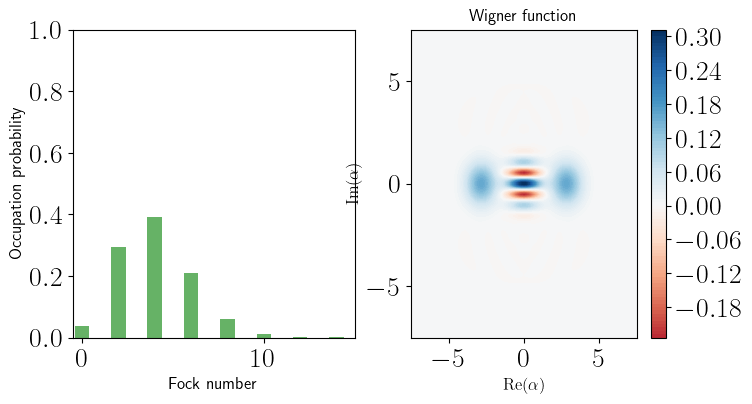

In [65]:
# initialize cat state
alpha = 2
cat_state = (coherent(N, alpha) + coherent(N,-alpha)).unit()
plot_wigner_fock_distribution(cat_state, colorbar=True);

### Get measurement results

In [243]:
# get p measurements
measurements_p_cat = get_measurements(np.pi/2,Ntrajs,cat_state) 
# get x measurements
measurements_x_cat = get_measurements(0,Ntrajs,cat_state) 

In [245]:
marginal_p_cat, cdf_p_cat, marginal_x_cat, cdf_x_cat = get_marginal(cat_state)

# kolmogorov-smirnov statistics  
ks_stat_x_cat = kstest(measurements_x_cat, cdf_x_cat)[0]
ks_stat_p_cat = kstest(measurements_p_cat, cdf_p_cat)[0]

ks_stat_p_cat, ks_stat_x_cat

(0.02005838757083099, 0.03277017933432269)

In [258]:
# histograms
# get histogram of p measurements
Nbins_p = 90
k = 5 # space space/ histogram limit
histogram_p, bins = np.histogram(measurements_p_cat, Nbins_p, [-k,k], density=True)

# get histogram of x measurements
Nbins_x = 40
histogram_x_cat, bins = np.histogram(measurements_x_cat, Nbins_x, [-k,k], density=True)

### x-quadrature

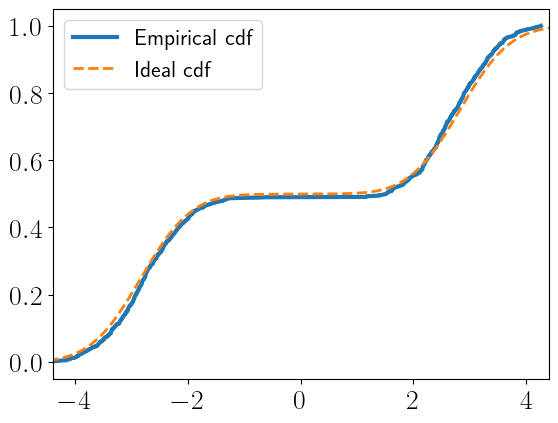

In [259]:
ecdf_x_cat = [ECDF(measurements_x_cat).x, ECDF(measurements_x_cat).y]

plt.plot(ecdf_x_cat[0], ecdf_x_cat[1], linewidth=3, label='Empirical cdf')
plt.plot(xlist,cdf_x_cat(xlist), '--', label='Ideal cdf', linewidth=2)
plt.xlim([-4.4,4.4])

plt.legend();

### p-quadrature

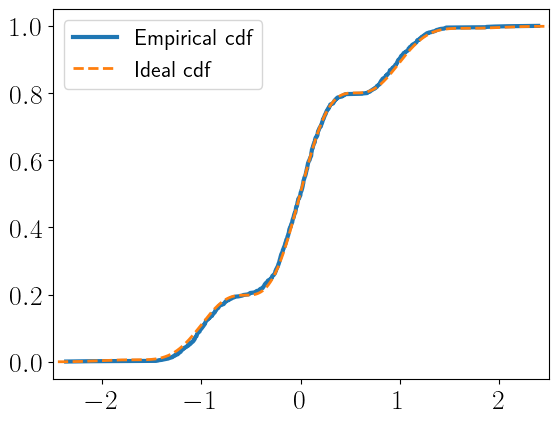

In [260]:
ecdf_p_cat = [ECDF(measurements_p_cat).x, ECDF(measurements_p_cat).y]

plt.plot(ecdf_p_cat[0], ecdf_p_cat[1], linewidth=3, label='Empirical cdf')
plt.plot(xlist,cdf_p_cat(xlist), '--', label='Ideal cdf', linewidth=2)
plt.xlim([-2.5,2.5])
plt.legend();

#### Plot

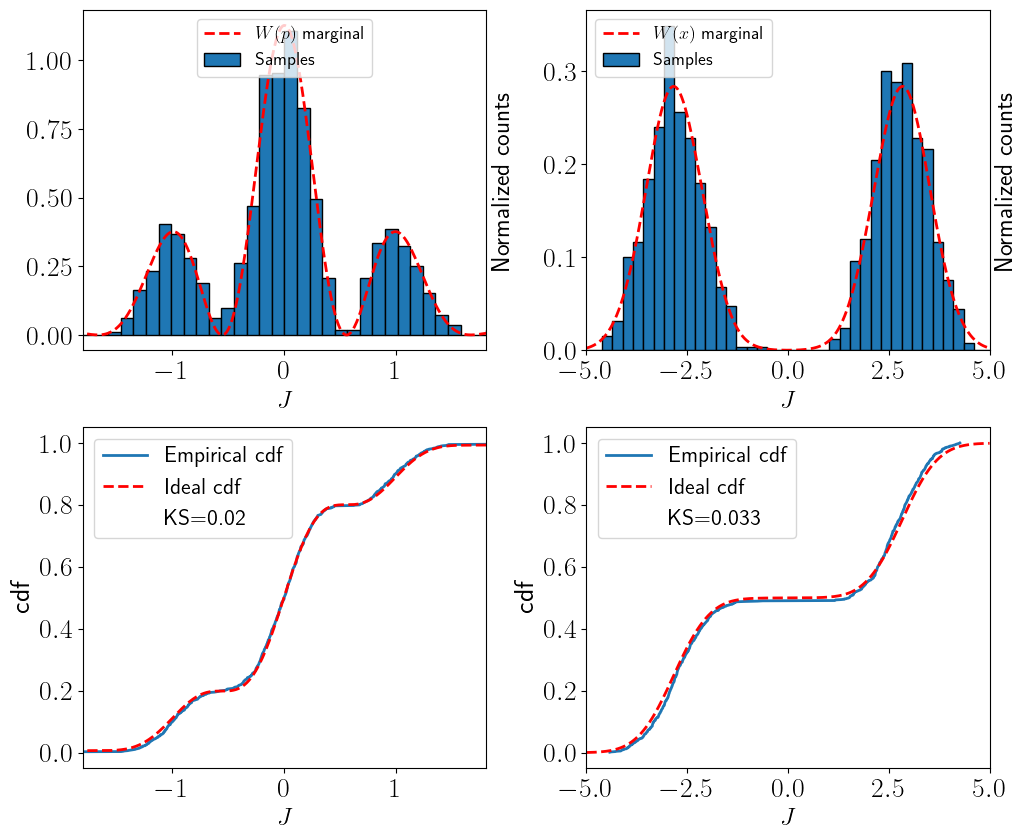

In [261]:
from matplotlib import ticker
fig, ax = plt.subplots(2,2, figsize=(10.5,8.5))
p_hist = np.linspace(-k,k,Nbins_p)
width_p = np.diff(p_hist)[0]

ax[0,0].bar(p_hist,histogram_p, align='center', width=width_p, edgecolor='k',label='Samples' );
fig1=ax[0,0].plot(xlist,marginal_p_cat, 'r--',linewidth=2, label='$W(p)$ marginal')
cut = 5
cut2 = 1.8
ax[0,0].set_xlim([-cut2,cut2])
ax[0,0].set_xlabel(r'$J$')
ax[0,0].set_ylabel(r'Normalized counts')
ax[0,0].yaxis.set_label_position("right")
ax[0,0].legend(loc='upper center',fontsize='13')
#ax[0,0].set_title(r'$p$-quadrature')


x_hist = np.linspace(-k,k,Nbins_x)
width_x = np.diff(x_hist)[0]
ax[0,1].bar(x_hist,histogram_x_cat, align='center', width=width_x, edgecolor='k',label='Samples' );
fig1=ax[0,1].plot(xlist,marginal_x_cat, 'r--',linewidth=2, label='$W(x)$ marginal')

ax[0,1].set_xlim([-cut,cut])
ax[0,1].set_xlabel(r'$J$')
ax[0,1].set_ylabel(r'Normalized counts')
ax[0,1].yaxis.set_label_position("right")
ax[0,1].legend(loc='upper left',fontsize='13')
#ax[0,1].set_title(r'$x$-quadrature')


ax[1,0].plot(ecdf_p_cat[0], ecdf_p_cat[1], linewidth=2, label='Empirical cdf')
ax[1,0].plot(xlist,cdf_p_cat(xlist), 'r--', label='Ideal cdf', linewidth=2)
ax[1,0].set_xlim([-cut2,cut2])
ax[1,0].set_xlabel(r'$J$')
ax[1,0].set_ylabel(r'cdf', fontsize=20)
ax[1,0].plot([], [], ' ', label="KS$=$"+str(np.round(ks_stat_p_cat,3)))
ax[1,0].legend()

ax[1,1].plot(ecdf_x_cat[0], ecdf_x_cat[1], linewidth=2, label='Empirical cdf')
ax[1,1].plot(xlist,cdf_x_cat(xlist), 'r--', label='Ideal cdf', linewidth=2)
ax[1,1].set_xlim([-cut,cut])
#ax[1,0].set_xlabel(r'$x $', fontsize=20)
ax[1,1].set_ylabel(r'cdf', fontsize=20)
#ax[1,0].set_title(r'Wigner function');
#ax[1,0].set_yticks([-5.0, 0.0, 5.0])
ax[1,1].set_xlabel(r'$J$')
ax[1,1].plot([], [], ' ', label="KS$=$"+str(np.round(ks_stat_x_cat,3)))
ax[1,1].legend()

#ax[1,0].set_ylim([-cut,cut])


plt.tight_layout()
#plt.savefig('homodyne_wigner_hist_alpha2cat_cdf.pdf')

### Coherent

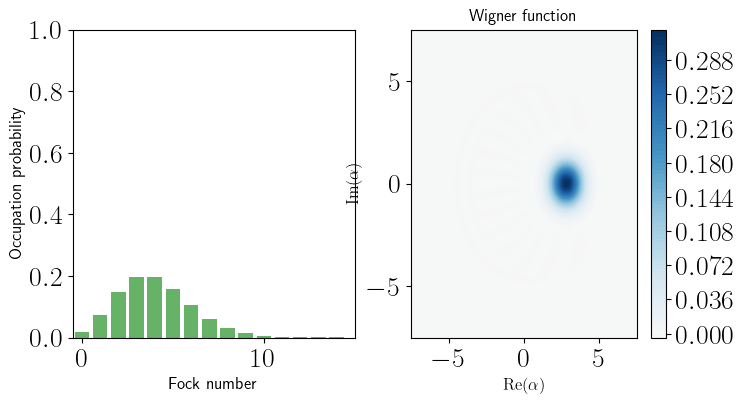

In [250]:
coherent_state = coherent(N, alpha)
plot_wigner_fock_distribution(coherent_state, colorbar=True);

In [251]:
# just get x_quadrature
measurements_x_coherent = get_measurements(0,Ntrajs, coherent_state)

In [271]:
histogram_x_coherent, bins = np.histogram(measurements_x_coherent, Nbins_x, [-k,k], density=True)

_, _, marginal_x_coherent, cdf_x_coherent = get_marginal(coherent_state)

# kolmogorov-smirnov statistics  
ks_stat_x_coherent = kstest(measurements_x_coherent, cdf_x_coherent)[0]
ecdf_x_coherent = [ECDF(measurements_x_coherent).x, ECDF(measurements_x_coherent).y]

### Fock

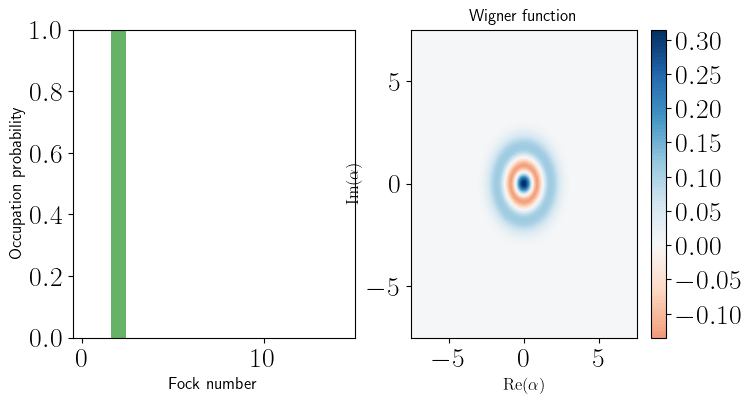

In [253]:
fock_state = fock(N, alpha)
plot_wigner_fock_distribution(fock_state, colorbar=True);

In [254]:
# just get x_quadrature
measurements_x_fock = get_measurements(0,Ntrajs, fock_state)

In [268]:
histogram_x_fock,bins = np.histogram(measurements_x_fock, Nbins_x, [-k,k], density=True)

_, _, marginal_x_fock, cdf_x_fock = get_marginal(fock_state)

# kolmogorov-smirnov statistics  
ks_stat_x_fock= kstest(measurements_x_fock, cdf_x_fock)[0]
ecdf_x_fock = [ECDF(measurements_x_fock).x, ECDF(measurements_x_fock).y]

## Plot

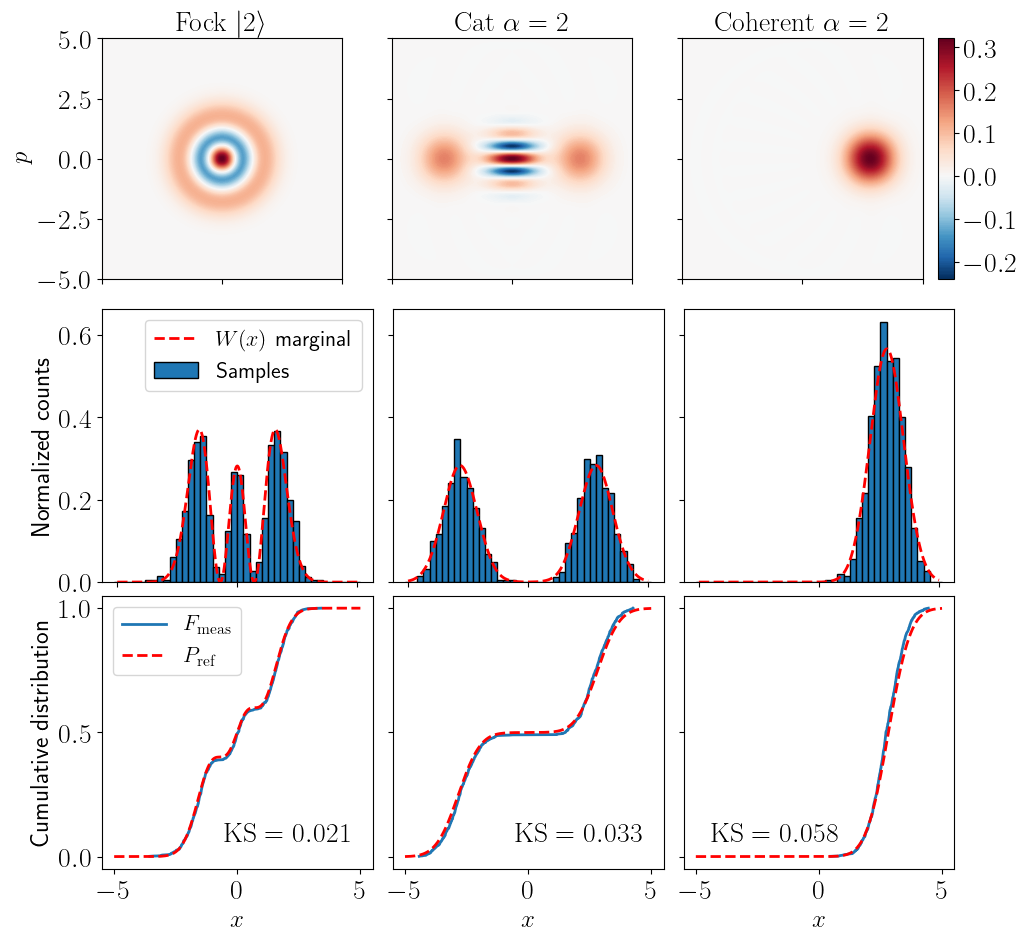

In [397]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(11,11))

grid = ImageGrid(fig, 311,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.5,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="edge",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

fig1= grid[0].contourf(xlist, xlist, W_fock, 200,norm=w_norm, cmap=mpl.cm.RdBu_r)
fig2 = grid[1].contourf(xlist, xlist, W_cat, 200,norm=w_norm, cmap=mpl.cm.RdBu_r)
fig3 = grid[2].contourf(xlist, xlist, W_coh, 200,norm=w_norm, cmap=mpl.cm.RdBu_r)

grid[0].set_ylabel('$p$')

grid[0].axes.xaxis.set_ticklabels([])
grid[1].axes.xaxis.set_ticklabels([])
grid[2].axes.xaxis.set_ticklabels([])

cb1 = grid[2].cax.colorbar(fig2)
tick_locator = ticker.MaxNLocator(nbins=6)
cb1.locator = tick_locator
cb1.update_ticks()

grid2 = ImageGrid(fig, 312,          
                 nrows_ncols=(1,3),
                 axes_pad=0.2,
                 share_all=True,
                 aspect = False,
                 )

x_hist = np.linspace(-k,k,Nbins_x)
width_x = np.diff(x_hist)[0]
grid2[0].bar(x_hist,histogram_x_fock, align='center', width=width_x, edgecolor='k',label='Samples' );
grid2[0].plot(xlist,marginal_x_fock, 'r--',linewidth=2, label='$W(x)$ marginal')

grid2[1].bar(x_hist,histogram_x_cat, align='center', width=width_x, edgecolor='k',label='Samples' );
grid2[1].plot(xlist,marginal_x_cat, 'r--',linewidth=2, label='$W(x)$ marginal')

grid2[2].bar(x_hist,histogram_x_coherent, align='center', width=width_x, edgecolor='k',label='Samples' );
fig4 = grid2[2].plot(xlist,marginal_x_coherent, 'r--',linewidth=2, label='$W(x)$ marginal')

grid2[0].set_ylabel(r'Normalized counts')

grid2[0].legend()

grid2[0].axes.xaxis.set_ticklabels([])

#grid2[0].set_ylim([0,5])
#grid2[0].axis('square')

#
#cut2 = 1.8
#ax[1].set_xlim([-cut2,cut2])
#ax[1].set_xlabel(r'$J$')
#ax[1].set_ylabel(r'Normalized counts')

#plt.subplots_adjust(hspace=-0.5)
plt.subplots_adjust(hspace=0.0)

grid3 = ImageGrid(fig, 313,          
                 nrows_ncols=(1,3),
                 axes_pad=0.2,
                 share_all=True,
                 aspect = False,
                 )

grid3[0].plot(ecdf_x_fock[0], ecdf_x_fock[1], linewidth=2, label='$F_\mathrm{meas}$')
grid3[0].plot(xlist,cdf_x_fock(xlist), 'r--', label='$P_\mathrm{ref}$', linewidth=2)

grid3[1].plot(ecdf_x_cat[0], ecdf_x_cat[1], linewidth=2, label='Empirical cdf')
grid3[1].plot(xlist,cdf_x_cat(xlist), 'r--', label='Ideal cdf', linewidth=2)

grid3[2].plot(ecdf_x_coherent[0], ecdf_x_coherent[1], linewidth=2, label='Empirical cdf')
grid3[2].plot(xlist,cdf_x_coherent(xlist), 'r--', label='Ideal cdf', linewidth=2)

grid3[0].set_ylabel(r'Cumulative distribution')

grid3[0].set_xlabel('$x$')
grid3[1].set_xlabel('$x$')
grid3[2].set_xlabel('$x$')

grid3[0].legend()

grid3[0].text(0.45, 0.1, r'$\mathrm{KS} = %s $'%(np.round(ks_stat_x_fock,3)), transform = grid3[0].transAxes, fontsize=20)

grid3[1].text(0.45, 0.1, r'$\mathrm{KS} = %s $'%(np.round(ks_stat_x_cat,3)), transform = grid3[1].transAxes, fontsize=20)

grid3[2].text(0.1, 0.1, r'$\mathrm{KS} = %s $'%(np.round(ks_stat_x_coherent,3)), transform = grid3[2].transAxes, fontsize=20)


grid[0].set_title(r'$\mathrm{Fock}\ |2\rangle$')
grid[1].set_title(r'$\mathrm{Cat}\ \alpha=2$')
grid[2].set_title(r'$\mathrm{Coherent}\ \alpha=2$')

plt.subplots_adjust(hspace=0.05)
plt.subplots_adjust(wspace=0.2)
#plt.savefig('homodyne_wigner_hist_cdf.pdf')